# MIT-GSL Uruguay 

## January 2020

-----

# Lesson - 1: Introduction to ML

** The first set of hands-on sessions are meant to provide a general overview of ML with the following topcs: **
1. Data import and export
2. Data pre-processing
3. Text pre-processing
4. Feature engineering
5. Cross-validation
5. High-dimensional modeling
6. Dimension reduction
6. Classification models:
    1. Logistic regression
    2. Regularized regression
    3. SVM
    4. Random Forests
    5. Boosted Trees
7. Model evaluation
8. Ensembling

** The class is desgined to be interactive. All the code and required data are provided. **

-----

Kaggle StumbleUpon Competition
==================
https://www.kaggle.com/c/stumbleupon

** About StumbleUpon **: User-curated web content discovery engine that recommends relevant, high quality pages and media to its users, based on their interests.

** Competition **: 
1. Some pages, such as news articles or seasonal recipes, are only relevant for a short period of time, others maintain a timeless quality and can be recommended to users long after they are discovered. 
2. Goal is to identify pages which are ephemeral and which are evergreen

** Objective **: Build classifier(s) to categorize webpages as evergreen (1) or non-evergreen (0)

** Evaluation **: Area under the curve (AUC)

** Data **: 
* Tab-separated file containing meta-data, webpage text (boilerplate), evergreen classification (target)
* Text based: high-dimensional
* Small sample size: prone to overfitting, high variance in results
    
** Notes **:
* We are only using the *train* data from the competition
* We will create our own split of training-val-test data
 


-----

Import Python Modules 
=================

In [14]:
# ==============================================
# 0. Module imports
# ==============================================

# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as st

# plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# dimension reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed  
import multiprocessing

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

# text mining
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

In [15]:
# ==============================================
# Working directory
# ==============================================

import os
os.chdir(os.path.join("..", "data"))
print(os.getcwd())

/home/rmsander/Documents/GSL/machine_learning_aws/data


Data import
=================

In [16]:
# ==============================================
# 1. Data import and explore
# ==============================================

# import
train = pd.read_table("stumbleupon/train.tsv", sep= "\t")


In [17]:
print("Data dimensions:" + str(train.shape))
display(train.head(10))

Data dimensions:(7395, 27)


,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0
5,http://www.conveniencemedical.com/genital-herp...,7018,"{""url"":""conveniencemedical genital herpes home...",?,?,119.000000,0.745455,0.581818,0.290909,0.018182,...,?,0,12,?,4368,55,3,0.054545,0.087356,0
6,http://gofashionlane.blogspot.tw/2012/06/ameri...,8685,"{""title"":""fashion lane American Wild Child "",""...",arts_entertainment,0.22111,0.773810,0.215054,0.053763,0.043011,0.043011,...,1,0,21,0,1287,93,3,0.548387,0.064327,1
7,http://www.insidershealth.com/article/racing_f...,3402,"{""url"":""insidershealth article racing for reco...",?,?,1.883333,0.719697,0.265152,0.113636,0.015152,...,?,0,5,?,27656,132,4,0.068182,0.148551,0
8,http://www.valetmag.com/the-handbook/features/...,477,"{""title"":""Valet The Handbook 31 Days 31 days"",...",?,?,0.471503,0.190722,0.036082,0.000000,0.000000,...,1,0,17,0,2471,194,7,0.644330,0.125000,1
9,http://www.howsweeteats.com/2010/03/24/cookies...,6731,"{""url"":""howsweeteats 2010 03 24 cookies and cr...",?,?,2.410112,0.469325,0.101227,0.018405,0.003067,...,?,1,14,?,11459,326,4,0.236196,0.094412,1


## Variable descriptions:

1. **url**: Url of the webpage to be classified
2. **urlid**: StumbleUpon's unique identifier for each url
3. **boilerplate**: Boilerplate text
4. **alchemy_category**:	Alchemy category
5. **alchemy_category_score**:	Alchemy category score
6. **avglinksize**:	Average number of words in each link
7. **commonLinkRatio_1**:	# of links sharing at least 1 word with 1 other links / # of links
8. **commonLinkRatio_2**:	# of links sharing at least 1 word with 2 other links / # of links
9. **commonLinkRatio_3**:	# of links sharing at least 1 word with 3 other links / # of links
10. **commonLinkRatio_4**:	# of links sharing at least 1 word with 4 other links / # of links
11. **compression_ratio**:	Compression achieved on this page via gzip (measure of redundancy)
12. **embed_ratio**: Count of number of "embed" usage
13. **frameBased**: A page is frame-based (1) if it has no body markup but have a frameset markup
14. **frameTagRatio**: Ratio of iframe markups over total number of markups
15. **hasDomainLink**:	True (1) if it contains an "a" with an url with domain
16. **html_ratio**:	Ratio of tags vs text in the page
17. **image_ratio**: Ratio of "img" tags vs text in the page
18. **is_news**: True (1) if StumbleUpon's news classifier determines that this webpage is news
19. **lengthyLinkDomain**: True (1) if at least 3 "a"'s text contains more than 30 alphanumeric characters
20. **linkwordscore**: Percentage of words on the page that are in hyperlink's text
21. **news_front_page**: True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
22. **non_markup_alphanum_characters**:	integer	Page's text's number of alphanumeric characters
23. **numberOfLinks**: Number of "a"  markups
24. **numwords_in_url**: Number of words in url
25. **parametrizedLinkRatio**: A link is parametrized if it's url contains parameters  or has an attached onClick event
26. **spelling_errors_ratio**: Ratio of words not found in wiki (considered to be a spelling mistake)
27. **label**: User-determined label. Either evergreen (1) or non-evergreen (0)


## Visualize and Describe Data

In [18]:
# data summary
train.describe()

,urlid,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,...,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
count,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.0,7395.000000,...,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000
mean,5305.704665,2.761823,0.468230,0.214080,0.092062,0.049262,2.255103,-0.103750,0.0,0.056423,...,0.233778,0.275709,0.660311,30.077079,5716.598242,178.754564,4.960649,0.172864,0.101221,0.513320
std,3048.384114,8.619793,0.203133,0.146743,0.095978,0.072629,5.704313,0.306545,0.0,0.041446,...,0.052487,1.919320,0.473636,20.393101,8875.432430,179.466198,3.233111,0.183286,0.079231,0.499856
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.000000,...,0.045564,-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2688.500000,1.602062,0.340370,0.105263,0.022222,0.000000,0.442616,0.000000,0.0,0.028502,...,0.201061,0.025900,0.000000,14.000000,1579.000000,82.000000,3.000000,0.040984,0.068739,0.000000
50%,5304.000000,2.088235,0.481481,0.202454,0.068627,0.022222,0.483680,0.000000,0.0,0.045775,...,0.230564,0.083051,1.000000,25.000000,3500.000000,139.000000,5.000000,0.113402,0.089312,1.000000
75%,7946.500000,2.627451,0.616604,0.300000,0.133333,0.065065,0.578227,0.000000,0.0,0.073459,...,0.260770,0.236700,1.000000,43.000000,6377.000000,222.000000,7.000000,0.241299,0.112376,1.000000
max,10566.000000,363.000000,1.000000,1.000000,0.980392,0.980392,21.000000,0.250000,0.0,0.444444,...,0.716883,113.333333,1.000000,100.000000,207952.000000,4997.000000,22.000000,1.000000,1.000000,1.000000


In [19]:
# target variable
train["label"].value_counts()

1    3796
0    3599
Name: label, dtype: int64

In [20]:
# set "?" as missing values
train = train.replace("?", np.nan)
train.head(100)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0
5,http://www.conveniencemedical.com/genital-herp...,7018,"{""url"":""conveniencemedical genital herpes home...",NaN,NaN,119.000000,0.745455,0.581818,0.290909,0.018182,...,NaN,0,12,NaN,4368,55,3,0.054545,0.087356,0
6,http://gofashionlane.blogspot.tw/2012/06/ameri...,8685,"{""title"":""fashion lane American Wild Child "",""...",arts_entertainment,0.22111,0.773810,0.215054,0.053763,0.043011,0.043011,...,1,0,21,0,1287,93,3,0.548387,0.064327,1
7,http://www.insidershealth.com/article/racing_f...,3402,"{""url"":""insidershealth article racing for reco...",NaN,NaN,1.883333,0.719697,0.265152,0.113636,0.015152,...,NaN,0,5,NaN,27656,132,4,0.068182,0.148551,0
8,http://www.valetmag.com/the-handbook/features/...,477,"{""title"":""Valet The Handbook 31 Days 31 days"",...",NaN,NaN,0.471503,0.190722,0.036082,0.000000,0.000000,...,1,0,17,0,2471,194,7,0.644330,0.125000,1
9,http://www.howsweeteats.com/2010/03/24/cookies...,6731,"{""url"":""howsweeteats 2010 03 24 cookies and cr...",NaN,NaN,2.410112,0.469325,0.101227,0.018405,0.003067,...,NaN,1,14,NaN,11459,326,4,0.236196,0.094412,1


In [21]:
# variable types
train.dtypes

url                                object
urlid                               int64
boilerplate                        object
alchemy_category                   object
alchemy_category_score             object
avglinksize                       float64
commonlinkratio_1                 float64
commonlinkratio_2                 float64
commonlinkratio_3                 float64
commonlinkratio_4                 float64
compression_ratio                 float64
embed_ratio                       float64
framebased                          int64
frameTagRatio                     float64
hasDomainLink                       int64
html_ratio                        float64
image_ratio                       float64
is_news                            object
lengthyLinkDomain                   int64
linkwordscore                       int64
news_front_page                    object
non_markup_alphanum_characters      int64
numberOfLinks                       int64
numwords_in_url                   

** Note **: Scikit-learn training algorithms do not accept categorical features and hence they need to be converted to numeric or binary before fitting the model 

In [24]:
# Fix variable types
# Some numeric variables are stored as string and can be directly converted
train[["alchemy_category_score", "is_news", "news_front_page"]] = train[["alchemy_category_score",
                                                                         "is_news", "news_front_page"]].astype(float)

train.dtypes

url                                object
urlid                               int64
boilerplate                        object
alchemy_category                   object
alchemy_category_score            float64
avglinksize                       float64
commonlinkratio_1                 float64
commonlinkratio_2                 float64
commonlinkratio_3                 float64
commonlinkratio_4                 float64
compression_ratio                 float64
embed_ratio                       float64
framebased                          int64
frameTagRatio                     float64
hasDomainLink                       int64
html_ratio                        float64
image_ratio                       float64
is_news                           float64
lengthyLinkDomain                   int64
linkwordscore                       int64
news_front_page                   float64
non_markup_alphanum_characters      int64
numberOfLinks                       int64
numwords_in_url                   

---

Explore 
==================

In [25]:
# ==============================================
# 2. Understanding variables
# ==============================================

# =============================
# 2.1 alchemy_category
# =============================
print(train["alchemy_category"].value_counts())

# Frequency table
pd.crosstab(train["alchemy_category"],train["label"])

recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64


label,0,1
alchemy_category,,
arts_entertainment,591,350
business,254,626
computer_internet,223,73
culture_politics,186,157
gaming,48,28
health,216,290
law_crime,18,13
recreation,388,841
religion,42,30


In [26]:
# percentages
pd.crosstab(train["alchemy_category"],train["label"]).apply(lambda x: np.round(x/x.sum(),2), axis=1)

label,0,1
alchemy_category,,
arts_entertainment,0.63,0.37
business,0.29,0.71
computer_internet,0.75,0.25
culture_politics,0.54,0.46
gaming,0.63,0.37
health,0.43,0.57
law_crime,0.58,0.42
recreation,0.32,0.68
religion,0.58,0.42


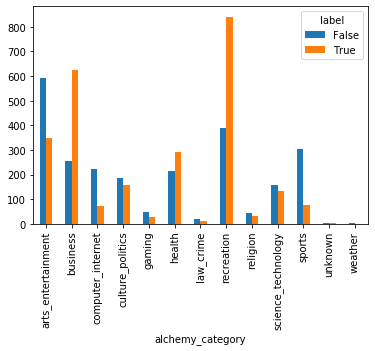

In [27]:
# plot
pd.crosstab(train.alchemy_category, train.label.astype(bool)).plot(kind="bar");

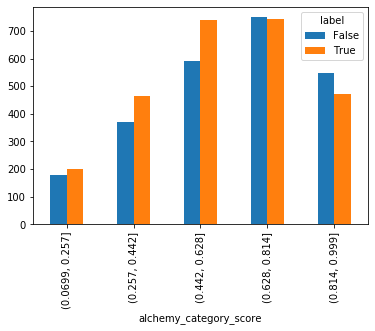

In [28]:
# =============================
# 2.2 alchemy_category_score
# =============================

# bin the continuous variable and check frequency within each bin
pd.crosstab(pd.cut(train["alchemy_category_score"], bins=5), train.label.astype(bool)).plot(kind="bar");

In [29]:
# =============================
# 2.3 avglinksize
# =============================

# bin the continuous variable and check frequency within each bin
pd.crosstab(pd.cut(train["avglinksize"], bins=5), train["label"].astype(bool))

label,False,True
avglinksize,,
"(-0.363, 72.6]",3593,3786
"(72.6, 145.2]",4,4
"(145.2, 217.8]",2,3
"(217.8, 290.4]",0,2
"(290.4, 363]",0,1


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


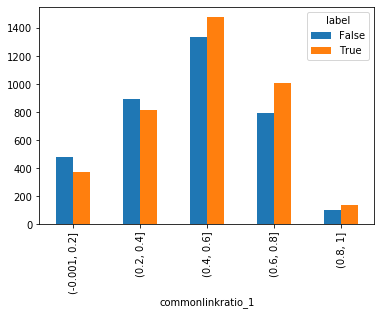

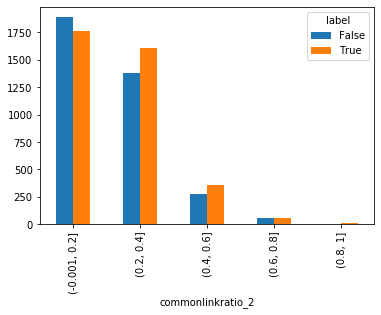

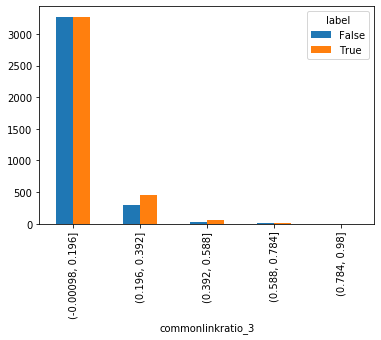

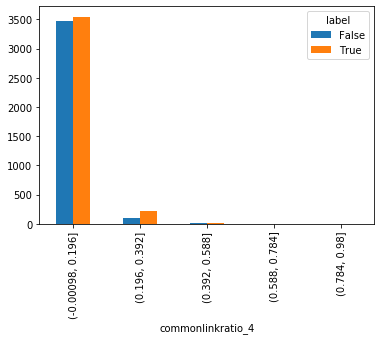

In [30]:
# =============================
# 2.4 commonlinkratio variables
# =============================

# bin the continuous variable and check frequency within each bin
print(pd.crosstab(pd.cut(train["commonlinkratio_1"], bins= 5), train.label.astype(bool)).plot(kind= "bar"));
print(pd.crosstab(pd.cut(train["commonlinkratio_2"], bins= 5), train.label.astype(bool)).plot(kind= "bar"));
print(pd.crosstab(pd.cut(train["commonlinkratio_3"], bins= 5), train.label.astype(bool)).plot(kind= "bar"));
print(pd.crosstab(pd.cut(train["commonlinkratio_4"], bins= 5), train.label.astype(bool)).plot(kind= "bar"));

In [31]:
# =============================
# 2.5 compression_ratio
# =============================

# bin the continuous variable and check frequency within each bin
pd.crosstab(pd.cut(train["compression_ratio"], bins= 5), train.label.astype(bool))

label,False,True
compression_ratio,,
"(-0.021, 4.2]",3232,3530
"(4.2, 8.4]",1,0
"(8.4, 12.6]",4,4
"(12.6, 16.8]",0,0
"(16.8, 21]",362,262


In [ ]:
# =============================
# 2.6 Other continuous variables
# =============================

print(pd.crosstab(pd.cut(train["embed_ratio"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))
print(pd.crosstab(pd.cut(train["numberOfLinks"],bins=10), train.label.astype(bool)).plot(kind= "bar"))
print(pd.crosstab(pd.cut(train["frameTagRatio"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))
print(pd.crosstab(pd.cut(train["html_ratio"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))
print(pd.crosstab(pd.cut(train["image_ratio"], bins= 10), train.label.astype(bool)).plot(kind= "bar"))

-----

# Class Exercise

### Make plots for the following continuous variables
1. lengthyLinkDomain
2. linkwordscore
3. non_markup_alphanum_characters
4. numberOfLinks
5. numwords_in_url
6. parametrizedLinkRatio
7. spelling_errors_ratio

** Note **: You may need to set the number of bins appropriately for each variable

In [ ]:
#print(pd.crosstab(pd.cut(train["lengthyLinkDomain"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))
#print(pd.crosstab(pd.cut(train["linkwordscore"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))
#print(pd.crosstab(pd.cut(train["non_markup_alphanum_characters"], bins= 7), train.label.astype(bool)).plot(kind= "bar"))
#print(pd.crosstab(pd.cut(train["numberOfLinks"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))
#print(pd.crosstab(pd.cut(train["numwords_in_url"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))
#print(pd.crosstab(pd.cut(train["parametrizedLinkRatio"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))
#print(pd.crosstab(pd.cut(train["spelling_errors_ratio"], bins= 5), train.label.astype(bool)).plot(kind= "bar"))

---

# Split data training, validation, and test


In [ ]:
# ==============================================
# 3. Prep for modeling
# ==============================================

# =============================
# Train-val-test split
# =============================

train, val = train_test_split(train, test_size= 0.5, train_size= 0.5, random_state= 234)
val, test = train_test_split(val, test_size= 0.5, train_size= 0.5, random_state= 675)
print("Train data size: " + str(train.shape))
print("Validation data size: " + str(val.shape))
print("Test data size: " + str(test.shape))

-----

## Check if the dependent variable has the same distribution in train, val, and test

In [ ]:
print(train["label"].value_counts()/train.shape[0])

In [ ]:
#print(val["label"].value_counts()/val.shape[0])

In [ ]:
#print(test["label"].value_counts()/test.shape[0])

--------

Modeling
===================

In [ ]:
# ==========================================
# 4. Modeling
# ==========================================

# =============================
# 4.1 Baseline model
#   Vanilla logistic regression
# =============================

# use only numeric variables without any missing values
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio"]

# fit logistic regression
logReg1 = LogisticRegression(penalty = "l2", C = 100000)
logReg1.fit(train[feat], train["label"])

In [ ]:
# predict on validation data
logReg1_val = pd.Series(logReg1.predict_proba(val[feat])[:,1])
print(logReg1_val.describe())
print(" -- -- -- ")

In [ ]:
# auc score
print("Baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg1_val.values), 5)))

---

Feature Engineering
=================

In [ ]:
# ==========================================
# 5. Feature engineering
# ==========================================

# =============================
# 5.1 Variables with missing 
#     values
# =============================

# find variables with missing values
print(np.sum(train.isnull()))

In [ ]:
# replace missing values -- alchemy_category_score 
train["alchemy_category_score"] = train["alchemy_category_score"].fillna(np.mean(train["alchemy_category_score"]))
val["alchemy_category_score"] = val["alchemy_category_score"].fillna(np.mean(train["alchemy_category_score"]))
test["alchemy_category_score"] = test["alchemy_category_score"].fillna(np.mean(train["alchemy_category_score"]))

In [ ]:
# is_news
print(train["is_news"].value_counts())

In [ ]:
train["is_news"] = train["is_news"].fillna(0)
pd.crosstab(train["is_news"],train["label"]).apply(lambda x: np.round(x/x.sum(),2), axis=1)

In [ ]:
# news_front_page
print(train["news_front_page"].value_counts())

In [ ]:
train["news_front_page"] = train["news_front_page"].fillna(2)
pd.crosstab(train["news_front_page"],train["label"]).apply(lambda x: np.round(x/x.sum(),2), axis=1)

---

In [ ]:
# =============================
# 4.2 Update baseline model
#   Vanilla logistic regression
# =============================

# use numeric variables with missing values imputed
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score"]

# fit logistic regression
logReg1 = LogisticRegression(penalty = "l2", C = 100000)
logReg1.fit(train[feat], train["label"])

# predict on validation data
logReg1_val = pd.Series(logReg1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("Updated baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg1_val.values), 5)))

---

In [ ]:
# ==========================================
# 5. Feature engineering
# ==========================================


# =============================
# 5.2.1 Categorical variables
# =============================

# alchemy_category
print(train["alchemy_category"].value_counts())
print(" --- ")
print(np.sum(train["alchemy_category"].isnull()))


# impute missing values as separate category
train["alchemy_category"] = train["alchemy_category"].fillna("_M")
val["alchemy_category"] = val["alchemy_category"].fillna("_M")
test["alchemy_category"] = test["alchemy_category"].fillna("_M")

print(" --- ")
print(pd.crosstab(train["alchemy_category"],train["label"]).apply(lambda x: np.round(x/x.sum(), 2), axis=1))

In [ ]:
# dummy variables for all categories
alch_train = pd.get_dummies(train["alchemy_category"], prefix= "al_cat")
print("Train dummies: " + str(alch_train.shape))

alch_val = pd.get_dummies(val["alchemy_category"], prefix= "al_cat")
print("Val dummies: " + str(alch_val.shape))

alch_test = pd.get_dummies(test["alchemy_category"], prefix= "al_cat")
print("Test dummies: " + str(alch_test.shape))

In [ ]:
print(list(alch_train.columns))
print(" --- ")
print(list(alch_val.columns))
print(" --- ")
print(list(alch_test.columns))

In [ ]:
# join with main data using indices
print(set(list(train.index)) == set(list(alch_train.index)))
print(set(list(val.index)) == set(list(alch_val.index)))
print(set(list(test.index)) == set(list(alch_test.index)))

train = train.join(alch_train)
val = val.join(alch_val)
test= test.join(alch_test)

train.head(100)

In [ ]:
list(train.columns)

---

In [ ]:
# =============================
# 4.3 Update baseline model
#   Vanilla logistic regression
# =============================

# use numeric variables with missing values imputed
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "al_cat__M", "al_cat_arts_entertainment", "al_cat_business", "al_cat_computer_internet",
        "al_cat_culture_politics", "al_cat_gaming", "al_cat_health", "al_cat_law_crime", "al_cat_recreation",
        "al_cat_religion", "al_cat_science_technology", "al_cat_sports"]

# fit logistic regression
logReg1 = LogisticRegression(penalty = "l2", C = 100000)
logReg1.fit(train[feat], train["label"])

# predict on validation data
logReg1_val = pd.Series(logReg1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("Updated baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg1_val.values), 5)))

---

In [ ]:
# ==========================================
# 5. Feature engineering
# ==========================================


# =============================
# 5.2.2 Categorical variables
# =============================

# Function to create n cross validation folds
def createFolds(df, nfolds):
    rows = df.shape[0]
    folds = list(range(0, nfolds))*int(np.ceil(float(rows)/nfolds))
    folds = folds[0:rows]
    np.random.shuffle(folds)
    folds = pd.Series(folds)
    return folds


# cross-fold category average
def cat_avg_cv(df, target, var, var_out, idcol, nfolds= 4, r1= 0.6, r2= 0.4):
    df = df[[idcol, target, var]]
    df_out = pd.DataFrame({idcol:[], var_out: []})
    folds = createFolds(df= df, nfolds= nfolds)
    for f in range(0, nfolds):
        print("Fold", f+1, "of", nfolds)
        tr = df.loc[folds.values == f, [idcol, var]]
        va = df.loc[folds.values != f, [var, target]]
        fold_mean = va[target].mean()
        va = va.groupby(var).agg({target: np.mean})
        va = pd.DataFrame({var: va.index, var_out: va[target]})
        va[var_out] = r1*va[var_out] + r2*fold_mean
        tr = pd.merge(tr, va, on= var, how= "left")
        tr = tr[[idcol, var_out]]
        df_out = df_out.append(tr)
    df_out = df_out.fillna(df[target].mean())
    return df_out


# for training data
alch_cat_cv = cat_avg_cv(train, "label", "alchemy_category", "alch_avg", 
                         idcol= "urlid", nfolds= 4, r1= 1.0, r2= 0.0)
print(alch_cat_cv.head(10))



In [ ]:
# use direct means for validation and testing data
alch_avg = train.groupby("alchemy_category").label.mean()
alch_avg = pd.DataFrame({"alchemy_category": alch_avg.index,
                         "alch_avg": alch_avg.values})
print(alch_avg)

# merge with train and val
train = pd.merge(train, alch_cat_cv, on= "urlid", how= "left")
val = pd.merge(val, alch_avg, on= "alchemy_category", how= "left")
test = pd.merge(test, alch_avg, on= "alchemy_category", how= "left")

---

In [ ]:
# =============================
# 4.4 Update baseline model
#   Vanilla logistic regression
# =============================

# use numeric variables with missing values imputed
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "alch_avg"]

# fit logistic regression
logReg2 = LogisticRegression(penalty = "l2", C = 100000)
logReg2.fit(train[feat], train["label"])

# predict on validation data
logReg2_val = pd.Series(logReg2.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("Updated baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg2_val.values), 5)))

### Penalized Logistic Regression

In [ ]:
# =============================
# 4.4.1 Penalized logistic regression
# =============================

# use numeric variables with missing values imputed
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "al_cat__M", "al_cat_arts_entertainment", "al_cat_business", "al_cat_computer_internet",
        "al_cat_culture_politics", "al_cat_gaming", "al_cat_health", "al_cat_law_crime", "al_cat_recreation",
        "al_cat_religion", "al_cat_science_technology", "al_cat_sports"]

# fit logistic regression
logReg2_1 = LogisticRegression(penalty = "l2", C = 5)
logReg2_1.fit(train[feat], train["label"])

# predict on validation data
logReg2_1_val = pd.Series(logReg2_1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("Updated baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg2_1_val.values), 5)))

## Gradient Boosting

In [ ]:
# =============================
# 4.5 Gradient Boosting
# =============================

# features to use
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "alch_avg"]

# simple gbm
gbm1 = GradientBoostingClassifier(loss = "deviance", learning_rate= 0.1, n_estimators= 100,
                                 max_depth= 2, min_samples_split= 10, min_samples_leaf= 10,
                                 subsample= 0.5, max_features= None, verbose= 0)
gbm1.fit(train[feat], train["label"])

# predict on validation data
gbm1_val = pd.Series(gbm1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("GBM: " + str(np.round(roc_auc_score(val["label"], gbm1_val.values), 5)))

In [ ]:
# important variables in gbm
gbm_feat_imp = pd.DataFrame({"feat": feat, "imp": np.round(gbm1.feature_importances_,3)})
gbm_feat_imp = gbm_feat_imp.sort_values(by= ["imp"], ascending= False)
gbm_feat_imp

In [ ]:
# bar graph to show feature importance
gbm_feat_imp = gbm_feat_imp.sort_values(by= ["imp"], ascending= True)
pos = np.arange(gbm_feat_imp.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.subplot(1, 1, 1)
plt.barh(pos, gbm_feat_imp.imp.values*100, align='center')
plt.yticks(pos, gbm_feat_imp.feat.values)
plt.xlabel("Importance")
plt.title("Variable Importance in Gradient Boosting")
plt.show()

In [ ]:
# Partial dependence plots
fig=plt.figure()
fig, axs = plot_partial_dependence(gbm1, train[feat], features= [20], 
                                   feature_names= feat, grid_resolution= 100) 
fig.suptitle('Partial dependence of plot')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show();

---

Text processing
=============

In [ ]:
# ==========================================
# 5. Feature engineering
# ==========================================


# =============================
# 5.3.1 Text features
# =============================

# simple text mining -- count number of words in each document 
count_dtm = CountVectorizer(min_df= 10,  max_features= 100, strip_accents= 'unicode',
                            analyzer= "word", token_pattern= r"\w{1,}", ngram_range=(1, 2), 
                            binary= True)
count_dtm.fit(train["boilerplate"])

In [ ]:
# create document term matrix
train_cnt_dtm = count_dtm.transform(train["boilerplate"])
val_cnt_dtm = count_dtm.transform(val["boilerplate"])
test_cnt_dtm = count_dtm.transform(test["boilerplate"])
print(train_cnt_dtm.shape); print(val_cnt_dtm.shape); print(test_cnt_dtm.shape)

---

In [ ]:
# =============================
# 4.6 Logistic with 
#     text features
# =============================

# fit logistic regression
logReg3 = LogisticRegression(penalty = "l2", C = 1)
logReg3.fit(train_cnt_dtm, train["label"])

# predict on validation data
logReg3_val = pd.Series(logReg3.predict(val_cnt_dtm))
print(" -- -- -- ")

# auc score
print("Logistic with text features: " + str(np.round(roc_auc_score(val["label"], logReg3_val.values), 5)))

---

In [ ]:
# =============================
# 5.3.2 Text features
# =============================

# TFIDF
idf_dtm = TfidfVectorizer(min_df= 10,  max_features= None, strip_accents= "unicode",
                          analyzer= "word", token_pattern= r"\w{1,}", ngram_range=(1, 2), 
                          use_idf= 1, smooth_idf= 1, sublinear_tf= 1)
idf_dtm.fit(train["boilerplate"])
train_idf_dtm = idf_dtm.transform(train["boilerplate"])
val_idf_dtm = idf_dtm.transform(val["boilerplate"])
test_idf_dtm = idf_dtm.transform(test["boilerplate"])
print(train_idf_dtm.shape); print(val_idf_dtm.shape); print(test_idf_dtm.shape)

---

In [ ]:
# =============================
# 4.6 Logistic with 
#     text features
# =============================

# fit logistic regression
logReg4 = LogisticRegression(penalty = "l2", C = 1)
logReg4.fit(train_idf_dtm, train["label"])

# predict on validation data
logReg4_val = pd.Series(logReg4.predict(val_idf_dtm))
print(" -- -- -- ")

# auc score
print("Logistic with text features: " + str(np.round(roc_auc_score(val["label"], logReg4_val.values), 5)))

---

Dimension reduction
===========

### Text feature selection using logistic regression

In [ ]:
# =============================
# 5.4 Feature selection
# =============================

def textFeatureSelect(dtm, target, model, tf_object, nfolds= 4, nreps= 2):
    feat_imp = pd.DataFrame({"feat":[], "imp": []})
    for r in range(0, nreps):
        print("Run", r+1, "of", nreps)
        folds = createFolds(df= dtm, nfolds= nfolds)
        for f in range(0, nfolds):
            print("Fold", f+1, "of", nfolds)
            tr = np.where(folds.values != f)[0]
            va = np.where(folds.values == f)[0]
            model.fit(dtm[tr,:], target[tr])
            imp = pd.DataFrame({"feat": tf_object.get_feature_names(), "imp": model.coef_[0,:]})
            imp["imp"] = imp["imp"].abs()
            feat_imp = feat_imp.append(imp)

    feat_imp = feat_imp.groupby("feat")
    feat_imp = feat_imp.agg({"imp": np.mean})
    feat_imp = pd.DataFrame({"feat": feat_imp.index, "imp": feat_imp.imp})
    feat_imp = feat_imp.sort_values(by = ["imp"], ascending= False)
    
    return feat_imp

In [ ]:
# Select best features from text data using logistic regression
model = LogisticRegression(penalty = "l2", C = 1)
imp_text_feat = textFeatureSelect(train_idf_dtm, target= train["label"].values, model= model, 
                                  tf_object= idf_dtm, nfolds= 4, nreps= 2)

In [ ]:
# important text features
print(imp_text_feat.head(20))

# keep the top 1000 ones
text_feat = imp_text_feat.iloc[0:1000, :]
idf_dtm_words = pd.DataFrame({"feat": idf_dtm.get_feature_names()})
idf_dtm_words = pd.merge(idf_dtm_words, text_feat, on= "feat", how= "inner", left_index= False, right_index= True)

# subset dtm with important features only
train_idf_dtm_sub = train_idf_dtm[:, idf_dtm_words.index]
val_idf_dtm_sub = val_idf_dtm[:, idf_dtm_words.index]
test_idf_dtm_sub = test_idf_dtm[:, idf_dtm_words.index]
print(" --- ")
print(train_idf_dtm_sub.shape); print(val_idf_dtm_sub.shape); print(val_idf_dtm_sub.shape)

---

In [ ]:
# =============================
# 4.7 Logistic with important
#     text features
# =============================

# fit logistic regression
logReg5 = LogisticRegression(penalty = "l2", C = 1)
logReg5.fit(train_idf_dtm_sub, train["label"])

# predict on validation data
logReg5_val = pd.Series(logReg5.predict_proba(val_idf_dtm_sub)[:,1])
print(" -- -- -- ")

# auc score
print("Logistic with text features: " + str(np.round(roc_auc_score(val["label"], logReg5_val.values), 5)))

----

# Class Exercise

### Build logistic regression model with different values of the penalty parameter. What do you find?

In [6]:
# =============================
# Class Exercise - varying penalty
# =============================

### Enter code here

---

In [7]:
# =============================
# 5.5 Dimension reduction -- PCA
# =============================

# 5.5.1 Sample fit

# Sample fit with 10 components
rpca = PCA(n_components = 10, random_state = 8795, svd_solver = "randomized")
rpca.fit(train_idf_dtm.toarray())
print ('Variance explained (first %d components): %.2f'%(10, sum(rpca.explained_variance_ratio_)*100))

# plot
exp_var = list((rpca.explained_variance_ratio_)*100)
x = range(10)
plt.bar(x, exp_var)
plt.xlabel("PCA components")
plt.ylabel("Explained variance ratio")
plt.show()

NameError: name 'train_idf_dtm' is not defined

In [ ]:
# fit with 100 components
rpca = PCA(n_components = 100, random_state = 8795, svd_solver = "randomized")
rpca.fit(train_idf_dtm.toarray())

# tranform dtm
train_idf_dtm_pca = rpca.transform(train_idf_dtm.toarray())
val_idf_dtm_pca = rpca.transform(val_idf_dtm.toarray())
test_idf_dtm_pca = rpca.transform(test_idf_dtm.toarray())
print(" --- ")
print(train_idf_dtm_pca.shape); print(val_idf_dtm_pca.shape); print(test_idf_dtm_pca.shape)

In [ ]:
# =============================
# 5.5 Dimension reduction
# =============================

# 5.5.2 Optimizing number of components

def pca_optimization(n_comp, train, val, training_target, validation_target, 
                     model, evaluation, classify=True):
    output = pd.DataFrame(columns=['n_comp', 'score'])

    for r in range(0,len(n_comp)):
        rpca = PCA(n_components = n_comp[r], random_state = 8756, svd_solver = "randomized") 
        rpca.fit(train.toarray())
    
        # tranform dtm
        train_pca = rpca.transform(train.toarray())
        val_pca = rpca.transform(val.toarray())
        print(" --- ")
        print('explained variance (first %d components): %.2f'%(n_comp[r], sum(rpca.explained_variance_ratio_)))

        if classify:   
            model.fit(train_pca, training_target)
            model_val = pd.Series(model.predict_proba(val_pca)[:,1])
        else:
            model.fit(train_pca, training_target)
            model_val = pd.Series(model.predict(val_pca))
        score = np.round(evaluation(validation_target, model_val.values), 5)
        data= {"id": n_comp[r],"score": score}
        output = output.append(pd.Series([n_comp[r], score], index=['n_comp','score']), ignore_index=True)
        
    return output

In [ ]:
# optimal number of pca components
model = LogisticRegression(penalty = "l2", C = 1)
pca_optimization(n_comp= [50, 100, 200], train= train_idf_dtm, val= val_idf_dtm, 
                 training_target= train["label"], validation_target= val["label"], model= model, 
                 evaluation= roc_auc_score, classify= True)


---

In [ ]:
# =============================
# 4.7 Logistic with PCA
# =============================

# fit logistic regression
logReg6 = LogisticRegression(penalty = "l2", C = 1)
logReg6.fit(train_idf_dtm_pca, train["label"])

# predict on validation data
logReg6_val = pd.Series(logReg6.predict_proba(val_idf_dtm_pca)[:,1])
print(" -- -- -- ")

# auc score
print("Logistic with text features: " + str(np.round(roc_auc_score(val["label"], logReg6_val.values), 5)))

In [ ]:
# =============================
# 4.8 Gradient Boosting with PCA
# =============================

# simple gbm
gbm2 = GradientBoostingClassifier(loss = "deviance", learning_rate= 0.1, n_estimators= 100,
                                 max_depth= 2, min_samples_split= 10, min_samples_leaf= 10,
                                 subsample= 0.5, max_features= None, verbose= 0)
gbm2.fit(train_idf_dtm_pca, train["label"])

# predict on validation data
gbm2_val = pd.Series(gbm2.predict_proba(val_idf_dtm_pca)[:,1])
print(" -- -- -- ")

# auc score
print("GBM: " + str(np.round(roc_auc_score(val["label"], gbm2_val.values), 5)))

-----

## Quick Ensemble

In [ ]:
# simple blend of logistic and GBM
simple_avg_val = np.mean([logReg5_val.values, gbm2_val.values], axis= 0)
print("Simple Avg:" + str(roc_auc_score(val["label"], simple_avg_val)))

-----

## Random Forests

In [ ]:
# =============================
# 4.9 Random Forest with PCA
#     and meta features
# =============================

# join meta features with pca features
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "alch_avg"]
train_combine = train[feat].join(pd.DataFrame(train_idf_dtm_pca, index= train.index))
val_combine = val[feat].join(pd.DataFrame(val_idf_dtm_pca, index= val.index))
test_combine = test[feat].join(pd.DataFrame(test_idf_dtm_pca, index= test.index))

# random forests
rf1 = RandomForestClassifier(n_estimators= 100, random_state= 9876, verbose= 1)
rf1.fit(train_combine, train["label"])

# predict on validation data
rf1_val = pd.Series(rf1.predict_proba(val_combine)[:,1])
print(" -- -- -- ")

# auc score
print("RF: " + str(np.round(roc_auc_score(val["label"], rf1_val.values), 5)))

In [ ]:
# simple blend of logistic, GBM, and RF
simple_avg_val = np.mean([logReg5_val.values, gbm2_val.values, rf1_val.values], axis= 0)
print("Simple Avg:" + str(roc_auc_score(val["label"], simple_avg_val)))

-----

## SGD

In [ ]:
# =============================
# 4.10 SGD on entire dtm
# =============================

# train sgd
sgd1 = SGDClassifier(loss = "log", penalty = "l2",
                     max_iter = 30, random_state = 34)
sgd1.fit(train_idf_dtm, train["label"])

# predict on validation data
sgd1_val = pd.Series(sgd1.predict_proba(val_idf_dtm)[:,1])
print(" -- -- -- ")

# auc score
print("SGD: " + str(np.round(roc_auc_score(val["label"], sgd1_val.values), 5)))

In [ ]:
# simple blend of logistic, GBM, RF, SGD
simple_avg_val = np.mean([logReg5_val.values, gbm2_val.values, rf1_val.values, sgd1_val.values], axis= 0)
print("Simple Avg:" + str(roc_auc_score(val["label"], simple_avg_val)))

---

# Cross Validation

In [ ]:
# ==========================================
# 6. Cross-validation
# ==========================================


# =============================
# 6.1 CV function - 1 
# =============================

#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning) 

def cross_val_model(train, target, model, nfolds= 4, classify= True):
        folds = KFold(n_splits = nfolds, shuffle= True, random_state = np.random.randint(1e4))
        if classify:
            preds = [np.array([model.fit(train[train_indices], 
                                         target[train_indices]).predict_proba(train[test_indices])[:,1], 
                               target[test_indices], test_indices])
                     for train_indices, test_indices in folds.split(train)]
        else:
            preds = [np.array([model.fit(train[train_indices], target[train_indices]).predict(train[test_indices]), 
                               target[test_indices], test_indices])
                     for train_indices, test_indices in folds.split(train)]
        
        preds = [preds[x].transpose() for x in range(len(preds))]
        preds = np.concatenate(preds, axis= 0)
        preds = pd.DataFrame(preds, columns= ["pred", "target", "index"])
        
        return preds

    
# serial version
# nreps = 4
# preds = [cross_val_model(tr_dtm, target, model= model, nfolds= 10, classify= True) for r in range(nreps)]

def cross_val_model_nrep(train, target, model, nfolds, nreps= 4, classify= True,
                         num_cores= 2, parallel= False, verbose= 0):
    if parallel:
        preds = Parallel(n_jobs= num_cores, 
                         verbose= verbose)(delayed(cross_val_model)(train, 
                                                                    target, model, nfolds= 10,
                                                                    classify= True) for r in range(nreps))
    else:
        preds = [cross_val_model(train, target, model= model, nfolds= 10, classify= True) for r in range(nreps)]
    preds = pd.DataFrame(np.concatenate(preds, axis= 0), columns= ["pred", "target", "index"])
    preds = preds.groupby(["index", "target"]).agg({"pred": np.mean})
    preds = preds.reset_index().sort_values(by= ["index"])
    return preds

In [ ]:
# =============================
# 6.2 Logistic CV
# =============================

logReg7_cv = LogisticRegression(penalty = "l2", C = 1)

# cv
logReg7_train = cross_val_model_nrep(train= train_idf_dtm, target= train.label.values, model= logReg7_cv, 
                                     nfolds= 10, nreps= 4, classify= True, num_cores= 4, parallel= True,
                                     verbose= 5)

# fit on entire training data to check on validation data
logReg7_val= pd.Series(logReg7_cv.fit(train_idf_dtm, train.label.values).predict_proba(val_idf_dtm)[:,1])
print(" -- -- -- ")

# auc score
print("Logistic cv score:" + str(np.round(roc_auc_score(train["label"], logReg7_train.pred.values), 5)))
print("Logistic val score:"  + str(np.round(roc_auc_score(val["label"], logReg7_val.values), 5)))

In [ ]:
# =============================
# 6.3 CV function - 2
# =============================

def cvModel(train, test, target, feat, model, idcol, nfolds= 2, nreps= 2, classify= True):
    ''' Train a model using k-fold cross validation
        and return cross-validated predictions on 
        training and test data sets
    '''
    val_pred = pd.DataFrame({idcol: [], 
                             'target': [],
                            'repeat':[], 
                            'fold': [], 
                            'pred': []})
    test_pred = pd.DataFrame(test[idcol])
    
    for r in range(0, nreps):
        folds = createFolds(train, nfolds)
        print("Run", r+1, "of", nreps)
        for f in range(0, nfolds):
            print("Fold", f+1, "of", nfolds)
            tr = folds.values != f
            va = folds.values == f
            model.fit(train.ix[tr, feat], target[tr])
            scored = pd.DataFrame({idcol: train.ix[va, idcol], 'target': target[va],
                                   'repeat': r, 'fold': f})
            tmp = 'pred' + str(r) + str(f)                    
            if classify:
                scored["pred"] = model.predict_proba(train.ix[va, feat])[:,1]
                test_pred[tmp] = model.predict_proba(test[feat])[:,1]
            else:
                scored["pred"] = model.predict(train.ix[va, feat])
                test_pred[tmp] = model.predict(test[feat])
            val_pred = val_pred.append(scored)
            
    val_pred = val_pred.groupby(idcol)
    val_pred = val_pred.agg({'target': np.mean,
                             'pred': np.mean})
    val_pred = val_pred.reset_index()
    val_pred = val_pred.sort_values(by= idcol)
    test_pred["pred"] = test_pred.ix[:,1:(test_pred.shape[1]+1)].mean(axis= 1)
    test_pred = test_pred[[idcol, "pred"]]
    
    return val_pred, test_pred



In [ ]:
# merge pca components with main
train_idf_dtm_pca = pd.DataFrame(train_idf_dtm_pca)
val_idf_dtm_pca = pd.DataFrame(val_idf_dtm_pca)
test_idf_dtm_pca = pd.DataFrame(test_idf_dtm_pca)

# give string names to columns
train_idf_dtm_pca.columns = ["pca" + str(i) for i in train_idf_dtm_pca.columns]
val_idf_dtm_pca.columns = ["pca" + str(i) for i in val_idf_dtm_pca.columns]
test_idf_dtm_pca.columns = ["pca" + str(i) for i in test_idf_dtm_pca.columns]

# generate index to merge on
train_idf_dtm_pca.index = train.index
val_idf_dtm_pca.index = val.index
test_idf_dtm_pca.index = test.index

# join
train_pca = train.join(train_idf_dtm_pca)
val_pca = val.join(val_idf_dtm_pca)
test_pca = test.join(test_idf_dtm_pca)
print(train_pca.shape); print(val_pca.shape); print(test_pca.shape);

In [ ]:
# =============================
# 6.4 Cross-val gbm
# =============================

# features to use
feat = list(train_idf_dtm_pca.columns.values)

# cv-gbm
gbm4 = GradientBoostingClassifier(loss = "deviance", n_estimators= 100,
                                  max_depth= 2, min_samples_split= 10, min_samples_leaf= 10,
                                  subsample= 0.75, max_features= None, verbose= 0)
gbm4_train, gbm4_val = cvModel(train_pca, val_pca, target= train_pca["label"], model= gbm4, feat= feat, 
                               idcol= "urlid", nfolds= 4, nreps= 2, classify= True)

print(" -- -- -- ")

# auc score
print("GBM cv score:" + str(np.round(roc_auc_score(gbm4_train.target.values, gbm4_train.pred.values), 5)))
print("GBM val score:" + str(np.round(roc_auc_score(val_pca["label"], gbm4_val.pred.values), 5)))

In [ ]:
# =============================
# 6.5 Cross-val RF
# =============================

# meta features with pca features
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "alch_avg"]
feat.extend(list(train_idf_dtm_pca.columns.values))

# cv-rf
rf2 = RandomForestClassifier(n_estimators= 100, min_samples_split= 5, random_state= 9876,
                             max_features= 15, verbose= 0)
rf2_train, rf2_val = cvModel(train_pca, val_pca, target= train_pca["label"], model= rf2, feat= feat, 
                               idcol= "urlid", nfolds= 4, nreps= 2, classify= True)

print(" -- -- -- ")

# auc score
print("RF cv score: " + str(np.round(roc_auc_score(rf2_train.target.values, rf2_train.pred.values), 5)))
print("RF val score: " + str(np.round(roc_auc_score(val_pca["label"], rf2_val.pred.values), 5)))

In [ ]:
# =============================
# 6.6 Cross-val ERT
# =============================


ert1_cv = ExtraTreesClassifier(n_estimators= 25, min_samples_split= 10, random_state= 134,
                               max_features= 55, min_samples_leaf= 5, verbose= 0)

ert1_train = cross_val_model_nrep(train= train_idf_dtm_sub, target= train.label.values, model= ert1_cv, 
                                     nfolds= 3, nreps= 8, classify= True, num_cores= 4, parallel= True,
                                     verbose= 5)

# fit on entire training data to check on validation data
print(" Fitting on entire training data ")
ert1_val= pd.Series(ert1_cv.fit(train_idf_dtm_sub, train.label.values).predict_proba(val_idf_dtm_sub)[:,1])
print(" -- -- -- ")

# auc score
print("ERT cv score: " + str(np.round(roc_auc_score(train["label"], ert1_train.pred.values), 5)))
print("ERT val score: "  + str(np.round(roc_auc_score(val["label"], ert1_val.values), 5)))

---

Ensemble learning
========================

In [ ]:
# ==========================================
# 7. Ensemble
# ==========================================


# =============================
# 7.1 Ensemble DF
# =============================

# order prediction data sets
train["sort_col"] = range(0, train.shape[0])
gbm4_train = pd.merge(gbm4_train, train[["urlid", "sort_col"]], on= "urlid", how= 'left').sort_values(by= ["sort_col"])
rf2_train = pd.merge(rf2_train, train[["urlid", "sort_col"]], on= "urlid", how= 'left').sort_values(by= ["sort_col"])

In [ ]:
# create data frame containing all predictions
train_ens = pd.DataFrame({"urlid": gbm4_train.urlid.values, "label": gbm4_train.target.values, 
                          "logReg7": logReg7_train.pred.values,
                          "gbm4": gbm4_train.pred.values, "rf2": rf2_train.pred.values,
                         "ert1": ert1_train.pred.values})
val_ens = pd.DataFrame({"urlid": gbm4_val.urlid.values, "gbm4": gbm4_val.pred.values,
                        "logReg7": logReg7_val.values, "rf2": rf2_val.pred.values,
                       "ert1": ert1_val.values})
val_ens = pd.merge(val_ens, val[["urlid", "label"]], on= "urlid")

print(train_ens.columns.values); print(val_ens.columns.values)

In [ ]:
# =============================
# 7.2 Simple average
# =============================

# simple average
simple_avg_train = np.mean([train_ens.gbm4.values, train_ens.rf2.values, train_ens.logReg7.values,
                           train_ens.ert1.values], axis= 0)
print("Simple avg cv: " + str(np.round(roc_auc_score(train_ens["label"], simple_avg_train), 5)))

simple_avg_val = np.mean([val_ens.gbm4.values, val_ens.rf2.values, val_ens.logReg7.values,
                         val_ens.ert1.values], axis= 0)
print("Simple avg val: " + str(np.round(roc_auc_score(val_ens["label"], simple_avg_val), 5)))

In [ ]:
# =============================
# 7.3 Weighted average
# Proportional representation vs. egalitarian democracy
# =============================

# weighted average
weight_avg_train = 0.8*train_ens.gbm4.values + 1.4*train_ens.logReg7.values
print("Weighted avg cv: " + str(np.round(roc_auc_score(train_ens["label"], weight_avg_train), 5)))

weight_avg_val = 0.8*val_ens.gbm4.values + 1.4*val_ens.logReg7.values
print("Weighted avg val: " + str(np.round(roc_auc_score(val_ens["label"], weight_avg_val), 5)))

In [ ]:
# =============================
# 7.4 Rank average
# =============================

# rank urlids by each prediction vector and then average
def get_ranked_preds(df, feat):
    for f in feat:
        df = df.sort_values(by = [f], ascending= True)
        df[f + "_rank"] = range(1, df.shape[0] + 1)
    return(df)

train_ens_rank = get_ranked_preds(train_ens, ["gbm4", "logReg7", "rf2", "ert1"])
val_ens_rank = get_ranked_preds(val_ens, ["gbm4", "logReg7", "rf2", "ert1"])

# simple average
rank_avg_train = np.mean([train_ens_rank.gbm4_rank.values, train_ens_rank.rf2_rank.values, 
                            train_ens_rank.logReg7_rank.values], axis= 0)
print("Rank avg cv: " + str(np.round(roc_auc_score(train_ens_rank["label"], rank_avg_train), 5)))


rank_avg_val = np.mean([val_ens_rank.gbm4_rank.values, val_ens_rank.rf2_rank.values, 
                            val_ens_rank.logReg7_rank.values], axis= 0)
print("Rank avg val: " + str(np.round(roc_auc_score(val_ens_rank["label"], rank_avg_val), 5)))

In [ ]:
# =============================
# 7.5 Stacked generalization
# =============================

# convert probabilities to logits
train_ens.describe()
feat = ["gbm4", "logReg7", "rf2", "ert1"]

train_ens[feat] = train_ens[feat].clip(0.01, 0.99)
val_ens[feat] = val_ens[feat].clip(0.01, 0.99)

train_ens[feat] = train_ens[feat].apply(st.logistic.ppf)
val_ens[feat] = val_ens[feat].apply(st.logistic.ppf)

print(" --- ")
print(train_ens.head())
print(val_ens.head())

In [ ]:
# Correlation matrix of predictions
feat = ["gbm4", "logReg7", "rf2", "ert1"]
train_ens[feat].corr()

In [ ]:
# Individual model scores
print("Logistic: " + str(np.round(roc_auc_score(val_ens["label"], val_ens["logReg7"]), 5)))
print("GBM: "  + str(np.round(roc_auc_score(val_ens["label"], val_ens["gbm4"]), 5)))
print("RF: "  + str(np.round(roc_auc_score(val_ens["label"], val_ens["rf2"]), 5)))
print("ERT: "  + str(np.round(roc_auc_score(val_ens["label"], val_ens["ert1"]), 5)))

In [ ]:
# build cv logistic
logReg8_ens = LogisticRegression()
feat = ["gbm4", "logReg7", "rf2", "ert1"]
logReg8_ens_cv, logReg8_ens_val = cvModel(train_ens, val_ens, target= train_ens["label"], model= logReg8_ens, 
                                          feat= feat, idcol= "urlid", nfolds= 4, nreps= 4, classify= True)

# auc score
print(" --- ")
print("Ensemble cv score: " + str(np.round(roc_auc_score(logReg8_ens_cv.target.values, logReg8_ens_cv.pred.values), 5)))
print("Ensemble val score: " + str(np.round(roc_auc_score(val_ens["label"], logReg8_ens_val.pred.values), 5)))

------

# Lesson summary

### What we've learned:
1. Process data
2. Visualize variables
3. Cross-tabulations
4. Missing value imputation
5. Manual feature engineering using categorical averages
5. Automated feature engineering using PCA
6. Text processing
7. Dealing with HD data
8. Cross-validation
9. Classification models
10. Ensemble learning

----